# Scam Token Detection — 3 Datasets × 3 Models (Balanced RF / MLP / SVM)

This notebook evaluates **3 models** across **3 datasets**:

- **Datasets**
  - **ChainAbuse (scam) + CoinMarketCap (licit)**
  - **TokenScout (scam) + TokenScout (licit)** *(heavily imbalanced, handled via SMOTE)*
  - **Combined (ChainAbuse + TokenScout + CMC)** *(balanced via downsampling)*

- **Models**
  - **Balanced Random Forest** (`imblearn.ensemble.BalancedRandomForestClassifier`)
  - **MLP** (`sklearn.neural_network.MLPClassifier`)
  - **SVM** (`sklearn.svm.SVC`)

## Efficiency Notes
- TokenScout scam dataset is large: we use **sampling + SMOTE** to keep training time reasonable.
- Preprocessing and feature selection are computed **once per dataset** and reused across all models.


# Scam Token Detection - SVM & MLP on ChainAbuse + CoinMarketCap

This notebook implements **SVM and MLP classifiers** using:
- **Algorithms**: SVM (RBF kernel) + Multi-Layer Perceptron
- **Data Sources**: ChainAbuse (scam) + CoinMarketCap (licit)

## Features
- ✅ Focused dataset (ChainAbuse + CoinMarketCap only)
- ✅ SVM with RBF kernel
- ✅ MLP with adaptive architecture
- ✅ SMOTE for class balancing
- ✅ Comprehensive evaluation metrics
- ✅ Model comparison
- ✅ SHAP interpretability (for MLP)

## Training Time
- SVM: ~10-20 minutes
- MLP: ~5-10 minutes
- Total: ~15-30 minutes


## 1. Imports and Configuration


In [1]:
import os
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    balanced_accuracy_score,
    matthews_corrcoef,
    f1_score,
    average_precision_score,
)

from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

# Plotting settings
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)

warnings.filterwarnings('ignore')

print("✓ Libraries imported")


✓ Libraries imported


## 2. Configuration


In [2]:
# Configuration
DATA_DIR_CANDIDATES = [
    '../data/dataset_with_features',  # if running from models/
    './data/dataset_with_features',   # if running from project root
    'data/dataset_with_features',
]
DATA_DIR = next((p for p in DATA_DIR_CANDIDATES if os.path.exists(p)), DATA_DIR_CANDIDATES[0])
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"Could not find dataset_with_features. Tried: {DATA_DIR_CANDIDATES}")

OUTPUT_DIR = './results_eval_3datasets_brf_mlp_svm'
SEED = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.1  # From train+val after test split

# Feature selection
VARIANCE_THRESHOLD = 0.001
CORRELATION_THRESHOLD = 0.95

# Dataset balancing (for efficiency + fairness)
BALANCE_TOKENSCOUT_DATASET = True
BALANCE_COMBINED_DATASET = True

# For combined-balanced: how to sample scams from the two scam sources
COMBINED_SCAM_SOURCE_WEIGHTS = {
    'chainabuse_scam_tokens': 0.5,
    'tokenscout_scam_tokens': 0.5,
}

# Balanced Random Forest configuration
BRF_PARAMS = {
    'n_estimators': 400,
    'random_state': SEED,
    'n_jobs': -1,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
}

# SVM Configuration
SVM_PARAMS = {
    'C': 10.0,
    'kernel': 'rbf',
    'gamma': 'scale',
    'class_weight': 'balanced',
    'probability': True,
    'random_state': SEED,
    'verbose': False,
    'max_iter': 5000,
    'cache_size': 2000,
}

# MLP Configuration
MLP_PARAMS = {
    'hidden_layer_sizes': (128, 64, 32),
    'activation': 'relu',
    'solver': 'adam',
    'alpha': 0.001,
    'batch_size': 256,
    'learning_rate': 'adaptive',
    'learning_rate_init': 0.001,
    'max_iter': 500,
    'early_stopping': True,
    'validation_fraction': 0.1,
    'n_iter_no_change': 20,
    'random_state': SEED,
    'verbose': False,
}

# SMOTE configuration (only used for unbalanced datasets like ChainAbuse+CMC)
SMOTE_PARAMS = {
    'sampling_strategy': 0.8,
    'random_state': SEED,
    'k_neighbors': 5,
}

# Source paths
CHAINABUSE_PATH = f'{DATA_DIR}/chainabuse_scam_tokens/features.csv'
CMC_PATH = f'{DATA_DIR}/cmc_licit_tokens/features.csv'
TOKENSCOUT_SCAM_PATH = f'{DATA_DIR}/tokenscout_scam_tokens/features.csv'
TOKENSCOUT_LICIT_PATH = f'{DATA_DIR}/tokenscout_licit_tokens/features.csv'

np.random.seed(SEED)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("=" * 80)
print("CONFIGURATION — 3 DATASETS × 3 MODELS (BRF / MLP / SVM)")
print("=" * 80)
print(f"Data Directory: {DATA_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"Random Seed: {SEED}")
print(f"Test Size: {TEST_SIZE * 100:.0f}%")
print(f"Validation Size: {VAL_SIZE * 100:.0f}% (from train+val after test split)")
print("\nDatasets:")
print("  1) ChainAbuse (scam) + CMC (licit)          [SMOTE for MLP/SVM]")
print("  2) TokenScout (scam/licit)                 [balanced via downsampling]")
print("  3) Combined (ChainAbuse + TokenScout + CMC) [balanced via downsampling]")
print("\nModels:")
print(f"  - BalancedRF: n_estimators={BRF_PARAMS['n_estimators']}")
print(f"  - SVM: kernel={SVM_PARAMS['kernel']}, C={SVM_PARAMS['C']}")
print(f"  - MLP: layers={MLP_PARAMS['hidden_layer_sizes']}")
print("=" * 80)


CONFIGURATION — 3 DATASETS × 3 MODELS (BRF / MLP / SVM)
Data Directory: ../data/dataset_with_features
Output Directory: ./results_eval_3datasets_brf_mlp_svm
Random Seed: 42
Test Size: 20%
Validation Size: 10% (from train+val after test split)

Datasets:
  1) ChainAbuse (scam) + CMC (licit)          [SMOTE for MLP/SVM]
  2) TokenScout (scam/licit)                 [balanced via downsampling]
  3) Combined (ChainAbuse + TokenScout + CMC) [balanced via downsampling]

Models:
  - BalancedRF: n_estimators=400
  - SVM: kernel=rbf, C=10.0
  - MLP: layers=(128, 64, 32)


## 3. Load Data


In [3]:
print("\nLoading source feature files...\n")

def read_features_csv(path: str) -> pd.DataFrame:
    """Read a features.csv file (try faster engine when available)."""
    try:
        return pd.read_csv(path, engine='pyarrow')
    except Exception:
        return pd.read_csv(path)

SOURCE_SPECS = {
    'chainabuse_scam_tokens': {'path': CHAINABUSE_PATH, 'target': 1},
    'cmc_licit_tokens': {'path': CMC_PATH, 'target': 0},
    'tokenscout_scam_tokens': {'path': TOKENSCOUT_SCAM_PATH, 'target': 1},
    'tokenscout_licit_tokens': {'path': TOKENSCOUT_LICIT_PATH, 'target': 0},
}

SOURCE_DFS = {}
for source_name, spec in SOURCE_SPECS.items():
    path = spec['path']
    print(f"- Loading {source_name}: {path}")
    df_src = read_features_csv(path)
    df_src['source_directory'] = source_name
    df_src['target'] = spec['target']
    SOURCE_DFS[source_name] = df_src
    print(f"  ✓ rows: {len(df_src):,} | columns: {df_src.shape[1]:,} | target={spec['target']}")

print("\n✓ All sources loaded")



Loading source feature files...

- Loading chainabuse_scam_tokens: ../data/dataset_with_features/chainabuse_scam_tokens/features.csv
  ✓ rows: 11,636 | columns: 150 | target=1
- Loading cmc_licit_tokens: ../data/dataset_with_features/cmc_licit_tokens/features.csv
  ✓ rows: 2,003 | columns: 150 | target=0
- Loading tokenscout_scam_tokens: ../data/dataset_with_features/tokenscout_scam_tokens/features.csv
  ✓ rows: 142,275 | columns: 150 | target=1
- Loading tokenscout_licit_tokens: ../data/dataset_with_features/tokenscout_licit_tokens/features.csv
  ✓ rows: 1,805 | columns: 150 | target=0

✓ All sources loaded


## 4. Feature Engineering


In [4]:
print("\nBuilding evaluation datasets...\n")

def downsample(df_in: pd.DataFrame, n: int, seed: int = SEED) -> pd.DataFrame:
    if n is None or n >= len(df_in):
        return df_in.copy()
    return df_in.sample(n=n, random_state=seed)

# 1) ChainAbuse (scam) + CMC (licit) — original distribution
df_chainabuse_cmc = pd.concat(
    [SOURCE_DFS['chainabuse_scam_tokens'], SOURCE_DFS['cmc_licit_tokens']],
    ignore_index=True,
)

# 2) TokenScout fraud/licit — USE ALL DATA (no downsampling), SMOTE will balance during training
_df_ts_scam = SOURCE_DFS['tokenscout_scam_tokens']
_df_ts_licit = SOURCE_DFS['tokenscout_licit_tokens']

# Concatenate all TokenScout data without balancing (heavily imbalanced: ~142k scam vs ~1.8k licit)
df_tokenscout = pd.concat([_df_ts_scam, _df_ts_licit], ignore_index=True)

# 3) Combined (ChainAbuse + TokenScout + CMC)
df_licit_combined = pd.concat(
    [SOURCE_DFS['cmc_licit_tokens'], SOURCE_DFS['tokenscout_licit_tokens']],
    ignore_index=True,
)

df_scam_chainabuse = SOURCE_DFS['chainabuse_scam_tokens']
df_scam_tokenscout = SOURCE_DFS['tokenscout_scam_tokens']

if BALANCE_COMBINED_DATASET:
    n_target = len(df_licit_combined)

    w_chainabuse = float(COMBINED_SCAM_SOURCE_WEIGHTS.get('chainabuse_scam_tokens', 0.5))
    w_tokenscout = float(COMBINED_SCAM_SOURCE_WEIGHTS.get('tokenscout_scam_tokens', 0.5))
    w_sum = (w_chainabuse + w_tokenscout) or 1.0
    w_chainabuse /= w_sum
    w_tokenscout /= w_sum

    n_chainabuse = int(round(n_target * w_chainabuse))
    n_tokenscout = n_target - n_chainabuse

    df_scam_sample = pd.concat(
        [downsample(df_scam_chainabuse, n_chainabuse), downsample(df_scam_tokenscout, n_tokenscout)],
        ignore_index=True,
    )

    df_combined = pd.concat([df_licit_combined, df_scam_sample], ignore_index=True)
else:
    df_combined = pd.concat([df_licit_combined, df_scam_chainabuse, df_scam_tokenscout], ignore_index=True)

# Shuffle (nicer splits)
df_chainabuse_cmc = df_chainabuse_cmc.sample(frac=1, random_state=SEED).reset_index(drop=True)
df_tokenscout = df_tokenscout.sample(frac=1, random_state=SEED).reset_index(drop=True)
df_combined = df_combined.sample(frac=1, random_state=SEED).reset_index(drop=True)

DATASETS = {
    'chainabuse+cmc': {'df': df_chainabuse_cmc, 'use_smote': True},
    'tokenscout_fraud_licit': {'df': df_tokenscout, 'use_smote': True},  # Now uses SMOTE (all 144k samples)
    'combined_balanced': {'df': df_combined, 'use_smote': False},
}

def dataset_overview(name: str, df_in: pd.DataFrame) -> None:
    counts = df_in['target'].value_counts().sort_index()
    sources = df_in['source_directory'].value_counts()
    print(f"\n{name}")
    print("-" * 80)
    print(f"Samples: {len(df_in):,}")
    print(f"Licit (0): {int(counts.get(0, 0)):,}")
    print(f"Scam  (1): {int(counts.get(1, 0)):,}")
    if int(counts.get(0, 0)) > 0:
        print(f"Imbalance ratio (scam/lict): {int(counts.get(1, 0)) / int(counts.get(0, 0)):.2f}")
    print("Sources:")
    print(sources)

for name, spec in DATASETS.items():
    dataset_overview(name, spec['df'])



Building evaluation datasets...


chainabuse+cmc
--------------------------------------------------------------------------------
Samples: 13,639
Licit (0): 2,003
Scam  (1): 11,636
Imbalance ratio (scam/lict): 5.81
Sources:
source_directory
chainabuse_scam_tokens    11636
cmc_licit_tokens           2003
Name: count, dtype: int64

tokenscout_fraud_licit
--------------------------------------------------------------------------------
Samples: 144,080
Licit (0): 1,805
Scam  (1): 142,275
Imbalance ratio (scam/lict): 78.82
Sources:
source_directory
tokenscout_scam_tokens     142275
tokenscout_licit_tokens      1805
Name: count, dtype: int64

combined_balanced
--------------------------------------------------------------------------------
Samples: 7,616
Licit (0): 3,808
Scam  (1): 3,808
Imbalance ratio (scam/lict): 1.00
Sources:
source_directory
cmc_licit_tokens           2003
chainabuse_scam_tokens     1904
tokenscout_scam_tokens     1904
tokenscout_licit_tokens    1805
Name: count, dtype

## 5. Train/Validation/Test Split


In [5]:
print("\nTraining + evaluating models on all datasets...\n")

# Threshold grid for validation tuning
THRESHOLDS = np.arange(0.1, 0.91, 0.01)

try:
    from IPython.display import display
except Exception:
    display = print


def prepare_Xy(df_in: pd.DataFrame):
    # Keep numeric features only
    exclude_cols = {'target', 'label', 'source_directory', 'token_address', 'token_file'}
    drop_cols = [c for c in df_in.columns if c in exclude_cols]
    X_df = df_in.drop(columns=drop_cols, errors='ignore')
    X_df = X_df.select_dtypes(include=[np.number]).copy()
    y = df_in['target'].astype(int).values
    return X_df, y


def fit_transform_feature_selection(X_train_df: pd.DataFrame, X_val_df: pd.DataFrame, X_test_df: pd.DataFrame):
    """Impute + variance threshold + correlation filter (fit only on train)."""

    # 1) Impute
    imputer = SimpleImputer(strategy='median')
    X_train_imp = imputer.fit_transform(X_train_df)
    X_val_imp = imputer.transform(X_val_df)
    X_test_imp = imputer.transform(X_test_df)

    # 2) Replace inf/-inf with finite values + clip to float32-safe range
    MAX_VAL = 1e10  # Safe for float32 (max ~3.4e38)
    X_train_imp = np.nan_to_num(X_train_imp, nan=0.0, posinf=MAX_VAL, neginf=-MAX_VAL)
    X_val_imp = np.nan_to_num(X_val_imp, nan=0.0, posinf=MAX_VAL, neginf=-MAX_VAL)
    X_test_imp = np.nan_to_num(X_test_imp, nan=0.0, posinf=MAX_VAL, neginf=-MAX_VAL)
    
    # Extra safety: clip any remaining extreme values
    X_train_imp = np.clip(X_train_imp, -MAX_VAL, MAX_VAL)
    X_val_imp = np.clip(X_val_imp, -MAX_VAL, MAX_VAL)
    X_test_imp = np.clip(X_test_imp, -MAX_VAL, MAX_VAL)

    # 3) Variance threshold
    var_sel = VarianceThreshold(threshold=VARIANCE_THRESHOLD)
    X_train_var = var_sel.fit_transform(X_train_imp)
    X_val_var = var_sel.transform(X_val_imp)
    X_test_var = var_sel.transform(X_test_imp)

    var_feature_names = list(X_train_df.columns[var_sel.get_support()])

    # 4) Correlation filter
    df_train_var = pd.DataFrame(X_train_var, columns=var_feature_names)
    corr = df_train_var.corr().abs().fillna(0.0)
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [c for c in upper.columns if any(upper[c] > CORRELATION_THRESHOLD)]

    keep_features = [c for c in var_feature_names if c not in to_drop]
    keep_idx = [var_feature_names.index(c) for c in keep_features]

    X_train_sel = X_train_var[:, keep_idx]
    X_val_sel = X_val_var[:, keep_idx]
    X_test_sel = X_test_var[:, keep_idx]

    meta = {
        'imputer': imputer,
        'var_selector': var_sel,
        'dropped_correlated': to_drop,
        'feature_names': keep_features,
    }
    return X_train_sel, X_val_sel, X_test_sel, meta


def optimize_threshold(y_true: np.ndarray, y_score: np.ndarray, thresholds=THRESHOLDS):
    best_t = 0.5
    best = -1.0
    for t in thresholds:
        pred = (y_score >= t).astype(int)
        score = balanced_accuracy_score(y_true, pred)
        if score > best:
            best = float(score)
            best_t = float(t)
    return best_t, best


def fit_eval_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0

    val_score = model.predict_proba(X_val)[:, 1]
    best_t, best_val_balacc = optimize_threshold(y_val, val_score)

    test_score = model.predict_proba(X_test)[:, 1]
    test_pred = (test_score >= best_t).astype(int)

    return {
        'train_time_s': float(train_time),
        'threshold': float(best_t),
        'val_bal_acc': float(best_val_balacc),
        'test_bal_acc': float(balanced_accuracy_score(y_test, test_pred)),
        'test_roc_auc': float(roc_auc_score(y_test, test_score)),
        'test_pr_auc': float(average_precision_score(y_test, test_score)),
        'test_mcc': float(matthews_corrcoef(y_test, test_pred)),
        'test_f1': float(f1_score(y_test, test_pred)),
        'cm': confusion_matrix(y_test, test_pred),
    }


results = []
confusion_matrices = {}  # (dataset, model) -> confusion matrix

for ds_name, ds_spec in DATASETS.items():
    df_ds = ds_spec['df']
    use_smote = bool(ds_spec.get('use_smote', False))

    X_df, y = prepare_Xy(df_ds)

    # Train/val/test split (per-dataset)
    X_temp, X_test_df, y_temp, y_test = train_test_split(
        X_df, y, test_size=TEST_SIZE, random_state=SEED, stratify=y
    )
    X_train_df, X_val_df, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=VAL_SIZE, random_state=SEED, stratify=y_temp
    )

    # Feature selection (fit only on train)
    X_train_sel, X_val_sel, X_test_sel, fs_meta = fit_transform_feature_selection(
        X_train_df, X_val_df, X_test_df
    )

    # Scale for MLP/SVM
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_sel)
    X_val_scaled = scaler.transform(X_val_sel)
    X_test_scaled = scaler.transform(X_test_sel)

    # SMOTE only for MLP/SVM when requested
    if use_smote:
        smote = SMOTE(**SMOTE_PARAMS)
        X_train_scaled_fit, y_train_fit = smote.fit_resample(X_train_scaled, y_train)
    else:
        X_train_scaled_fit, y_train_fit = X_train_scaled, y_train

    models = {
        'BalancedRF': BalancedRandomForestClassifier(**BRF_PARAMS),
        'MLP': MLPClassifier(**MLP_PARAMS),
        'SVM': SVC(**SVM_PARAMS),
    }

    print(f"\n{'='*80}")
    print(f"DATASET: {ds_name}")
    print(f"{'='*80}")
    print(f"Samples: {len(df_ds):,} | raw numeric features: {X_df.shape[1]:,} | selected: {len(fs_meta['feature_names']):,}")
    print(f"Train/Val/Test: {len(y_train):,}/{len(y_val):,}/{len(y_test):,}")
    if use_smote:
        print(f"SMOTE (train only, for MLP/SVM): {len(y_train):,} -> {len(y_train_fit):,}")

    for model_name, model in models.items():
        if model_name == 'BalancedRF':
            res = fit_eval_model(model, X_train_sel, y_train, X_val_sel, y_val, X_test_sel, y_test)
            train_rows_fit = len(y_train)
            smote_used = False
        else:
            res = fit_eval_model(model, X_train_scaled_fit, y_train_fit, X_val_scaled, y_val, X_test_scaled, y_test)
            train_rows_fit = len(y_train_fit)
            smote_used = use_smote

        confusion_matrices[(ds_name, model_name)] = res['cm']

        results.append({
            'dataset': ds_name,
            'model': model_name,
            'n_samples': int(len(df_ds)),
            'n_features_selected': int(len(fs_meta['feature_names'])),
            'train_rows_fit': int(train_rows_fit),
            'smote': bool(smote_used),
            'threshold': res['threshold'],
            'val_bal_acc': res['val_bal_acc'],
            'test_bal_acc': res['test_bal_acc'],
            'test_roc_auc': res['test_roc_auc'],
            'test_pr_auc': res['test_pr_auc'],
            'test_mcc': res['test_mcc'],
            'test_f1': res['test_f1'],
            'train_time_s': res['train_time_s'],
        })

        print(
            f"- {model_name:10s} | bal_acc={res['test_bal_acc']:.4f} | roc_auc={res['test_roc_auc']:.4f} | "
            f"pr_auc={res['test_pr_auc']:.4f} | f1={res['test_f1']:.4f} | t={res['threshold']:.2f} | "
            f"train={res['train_time_s']:.1f}s"
        )

results_df = pd.DataFrame(results).sort_values(['dataset', 'model']).reset_index(drop=True)

print(f"\n{'='*80}")
print("SUMMARY (test metrics)")
print(f"{'='*80}")
display(results_df)

balacc_pivot = results_df.pivot(index='dataset', columns='model', values='test_bal_acc')
print("\nBalanced Accuracy (test) — pivot:")
display(balacc_pivot)

results_path = os.path.join(OUTPUT_DIR, 'results_3datasets_brf_mlp_svm.csv')
results_df.to_csv(results_path, index=False)
print(f"\n✓ Saved results to: {results_path}")



Training + evaluating models on all datasets...


DATASET: chainabuse+cmc
Samples: 13,639 | raw numeric features: 146 | selected: 87
Train/Val/Test: 9,819/1,092/2,728
SMOTE (train only, for MLP/SVM): 9,819 -> 15,078
- BalancedRF | bal_acc=0.9769 | roc_auc=0.9907 | pr_auc=0.9984 | f1=0.9796 | t=0.59 | train=1.0s
- MLP        | bal_acc=0.9680 | roc_auc=0.9905 | pr_auc=0.9985 | f1=0.9833 | t=0.86 | train=5.0s
- SVM        | bal_acc=0.9516 | roc_auc=0.9905 | pr_auc=0.9984 | f1=0.9814 | t=0.58 | train=5.2s

DATASET: tokenscout_fraud_licit
Samples: 144,080 | raw numeric features: 146 | selected: 89
Train/Val/Test: 103,737/11,527/28,816
SMOTE (train only, for MLP/SVM): 103,737 -> 184,386
- BalancedRF | bal_acc=0.8756 | roc_auc=0.9415 | pr_auc=0.9992 | f1=0.9140 | t=0.48 | train=3.0s
- MLP        | bal_acc=0.6618 | roc_auc=0.8622 | pr_auc=0.9970 | f1=0.9844 | t=0.89 | train=138.9s
- SVM        | bal_acc=0.6075 | roc_auc=0.6485 | pr_auc=0.9927 | f1=0.6199 | t=0.47 | train=1605.5s

DATASET: com

,dataset,model,n_samples,n_features_selected,train_rows_fit,smote,threshold,val_bal_acc,test_bal_acc,test_roc_auc,test_pr_auc,test_mcc,test_f1,train_time_s
0,chainabuse+cmc,BalancedRF,13639,87,9819,False,0.59,0.984979,0.976921,0.990730,0.998407,0.881278,0.979637,0.999869
1,chainabuse+cmc,MLP,13639,87,15078,True,0.86,0.985609,0.967975,0.990512,0.998484,0.894574,0.983286,4.983530
2,chainabuse+cmc,SVM,13639,87,15078,True,0.58,0.983557,0.951593,0.990488,0.998438,0.878515,0.981409,5.232437
3,combined_balanced,BalancedRF,7616,91,5482,False,0.41,0.888525,0.903543,0.963188,0.966415,0.807755,0.905466,1.109716
4,combined_balanced,MLP,7616,91,5482,False,0.41,0.878689,0.902887,0.952895,0.958073,0.806675,0.905128,1.459880
5,combined_balanced,SVM,7616,91,5482,False,0.60,0.893443,0.904856,0.945929,0.943140,0.809745,0.905291,3.100781
6,tokenscout_fraud_licit,BalancedRF,144080,89,103737,False,0.48,0.876764,0.875573,0.941511,0.999171,0.224077,0.913977,3.030137
7,tokenscout_fraud_licit,MLP,144080,89,184386,True,0.89,0.662893,0.661761,0.862213,0.996950,0.222848,0.984371,138.892407
8,tokenscout_fraud_licit,SVM,144080,89,184386,True,0.47,0.597964,0.607539,0.648462,0.992717,0.048106,0.619923,1605.510934



Balanced Accuracy (test) — pivot:


model,BalancedRF,MLP,SVM
dataset,,,
chainabuse+cmc,0.976921,0.967975,0.951593
combined_balanced,0.903543,0.902887,0.904856
tokenscout_fraud_licit,0.875573,0.661761,0.607539



✓ Saved results to: ./results_eval_3datasets_brf_mlp_svm/results_3datasets_brf_mlp_svm.csv


## 6. Train SVM Model


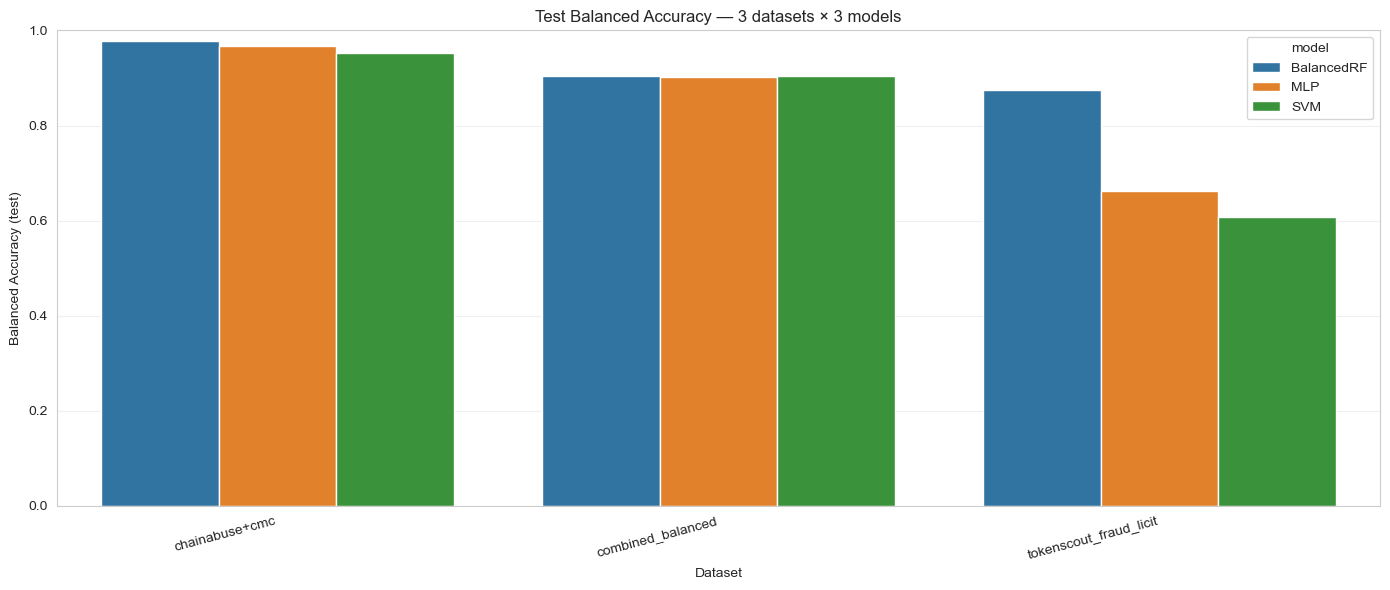

✓ Saved plot to: ./results_eval_3datasets_brf_mlp_svm/balanced_accuracy_comparison.png


In [6]:
if 'results_df' not in globals():
    raise RuntimeError("Run the previous cell first to generate results_df")

plt.figure(figsize=(14, 6))
sns.barplot(data=results_df, x='dataset', y='test_bal_acc', hue='model')
plt.ylim(0, 1.0)
plt.title('Test Balanced Accuracy — 3 datasets × 3 models')
plt.ylabel('Balanced Accuracy (test)')
plt.xlabel('Dataset')
plt.xticks(rotation=15, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()

out_path = os.path.join(OUTPUT_DIR, 'balanced_accuracy_comparison.png')
plt.savefig(out_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved plot to: {out_path}")


## 7. Train MLP Model


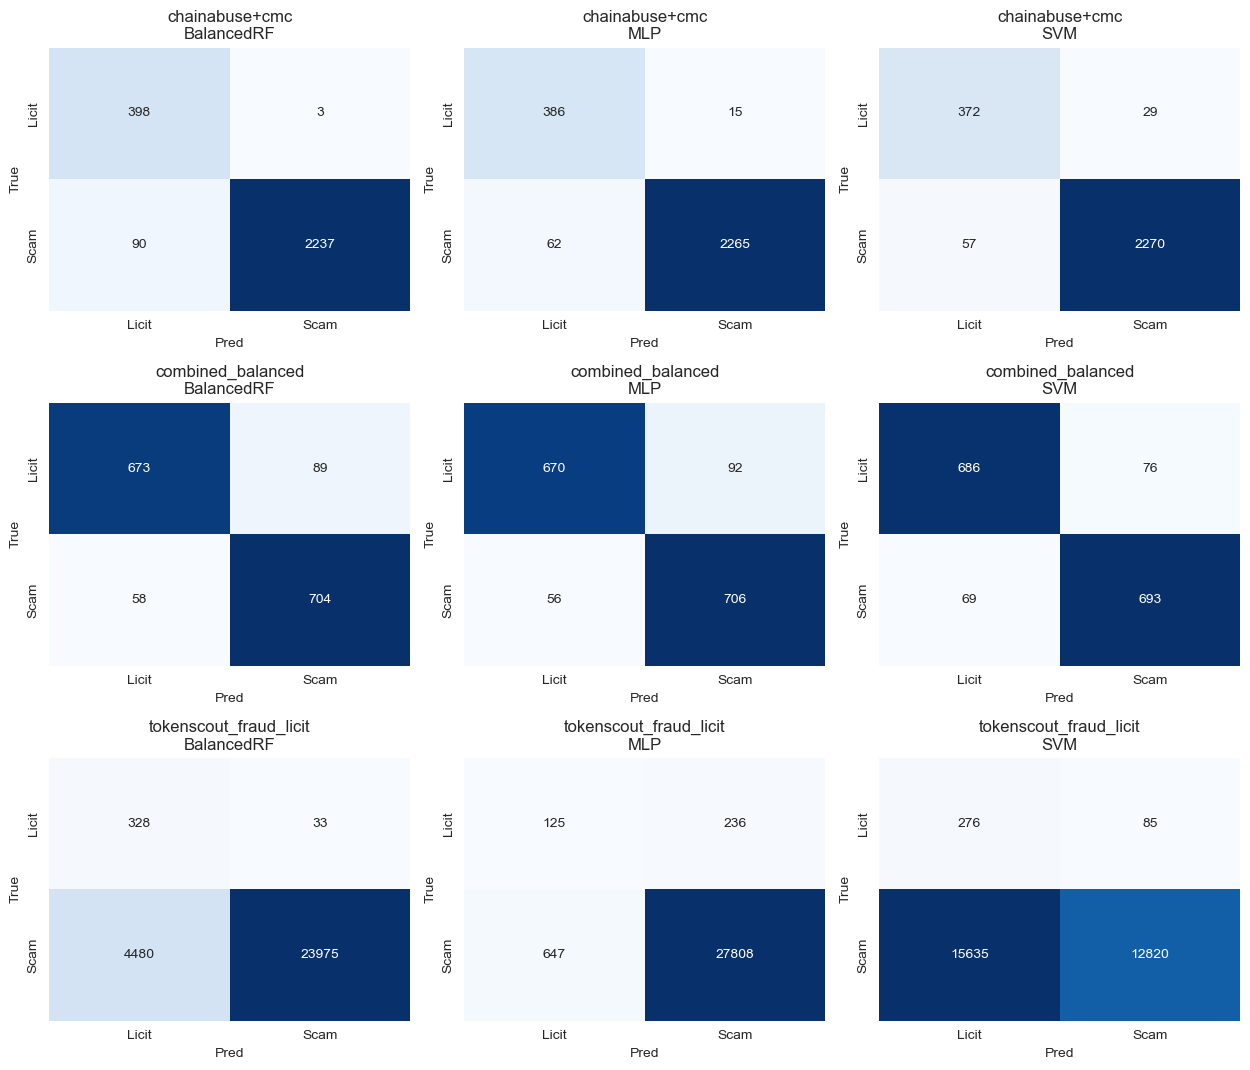

✓ Saved confusion matrix grid to: ./results_eval_3datasets_brf_mlp_svm/confusion_matrices_grid.png


In [7]:
if 'results_df' not in globals() or 'confusion_matrices' not in globals():
    raise RuntimeError("Run the evaluation cell first to generate results_df + confusion_matrices")

datasets = list(results_df['dataset'].unique())
models = list(results_df['model'].unique())

fig, axes = plt.subplots(len(datasets), len(models), figsize=(4.2 * len(models), 3.6 * len(datasets)))

# Make axes always 2D
if len(datasets) == 1 and len(models) == 1:
    axes = np.array([[axes]])
elif len(datasets) == 1:
    axes = np.array([axes])
elif len(models) == 1:
    axes = np.array([[ax] for ax in axes])

for i, ds in enumerate(datasets):
    for j, model in enumerate(models):
        ax = axes[i, j]
        cm = confusion_matrices.get((ds, model))
        if cm is None:
            ax.axis('off')
            continue

        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False,
            ax=ax,
            xticklabels=['Licit', 'Scam'],
            yticklabels=['Licit', 'Scam'],
        )
        ax.set_title(f"{ds}\n{model}")
        ax.set_xlabel('Pred')
        ax.set_ylabel('True')

plt.tight_layout()

out_path = os.path.join(OUTPUT_DIR, 'confusion_matrices_grid.png')
plt.savefig(out_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved confusion matrix grid to: {out_path}")


## 8. Threshold Optimization


In [8]:
if 'results_df' not in globals():
    raise RuntimeError("Run the evaluation cell first to generate results_df")

try:
    from IPython.display import display
except Exception:
    display = print

cols = [
    'dataset',
    'model',
    'threshold',
    'val_bal_acc',
    'test_bal_acc',
    'test_roc_auc',
    'test_pr_auc',
    'test_f1',
]

display(results_df[cols].sort_values(['dataset', 'model']).reset_index(drop=True))


,dataset,model,threshold,val_bal_acc,test_bal_acc,test_roc_auc,test_pr_auc,test_f1
0,chainabuse+cmc,BalancedRF,0.59,0.984979,0.976921,0.990730,0.998407,0.979637
1,chainabuse+cmc,MLP,0.86,0.985609,0.967975,0.990512,0.998484,0.983286
2,chainabuse+cmc,SVM,0.58,0.983557,0.951593,0.990488,0.998438,0.981409
3,combined_balanced,BalancedRF,0.41,0.888525,0.903543,0.963188,0.966415,0.905466
4,combined_balanced,MLP,0.41,0.878689,0.902887,0.952895,0.958073,0.905128
5,combined_balanced,SVM,0.60,0.893443,0.904856,0.945929,0.943140,0.905291
6,tokenscout_fraud_licit,BalancedRF,0.48,0.876764,0.875573,0.941511,0.999171,0.913977
7,tokenscout_fraud_licit,MLP,0.89,0.662893,0.661761,0.862213,0.996950,0.984371
8,tokenscout_fraud_licit,SVM,0.47,0.597964,0.607539,0.648462,0.992717,0.619923
